<h2> Import libraries <h2>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm


<h2> Read the data <h2>

In [4]:
df = pd.read_csv('baku_air_quality_data.csv')

<h2>  Convert timestamp to datetime<h2>

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

<h2> Setting the datetime as an index

In [6]:
df.set_index('timestamp' ,inplace = True)

<h2> Looking at the daily average  AQI <h2>

In [7]:
daily_aqi = df['aqi'].resample('D').mean()

<h1> Plotting the daily average AQI values for the entire period <h1>

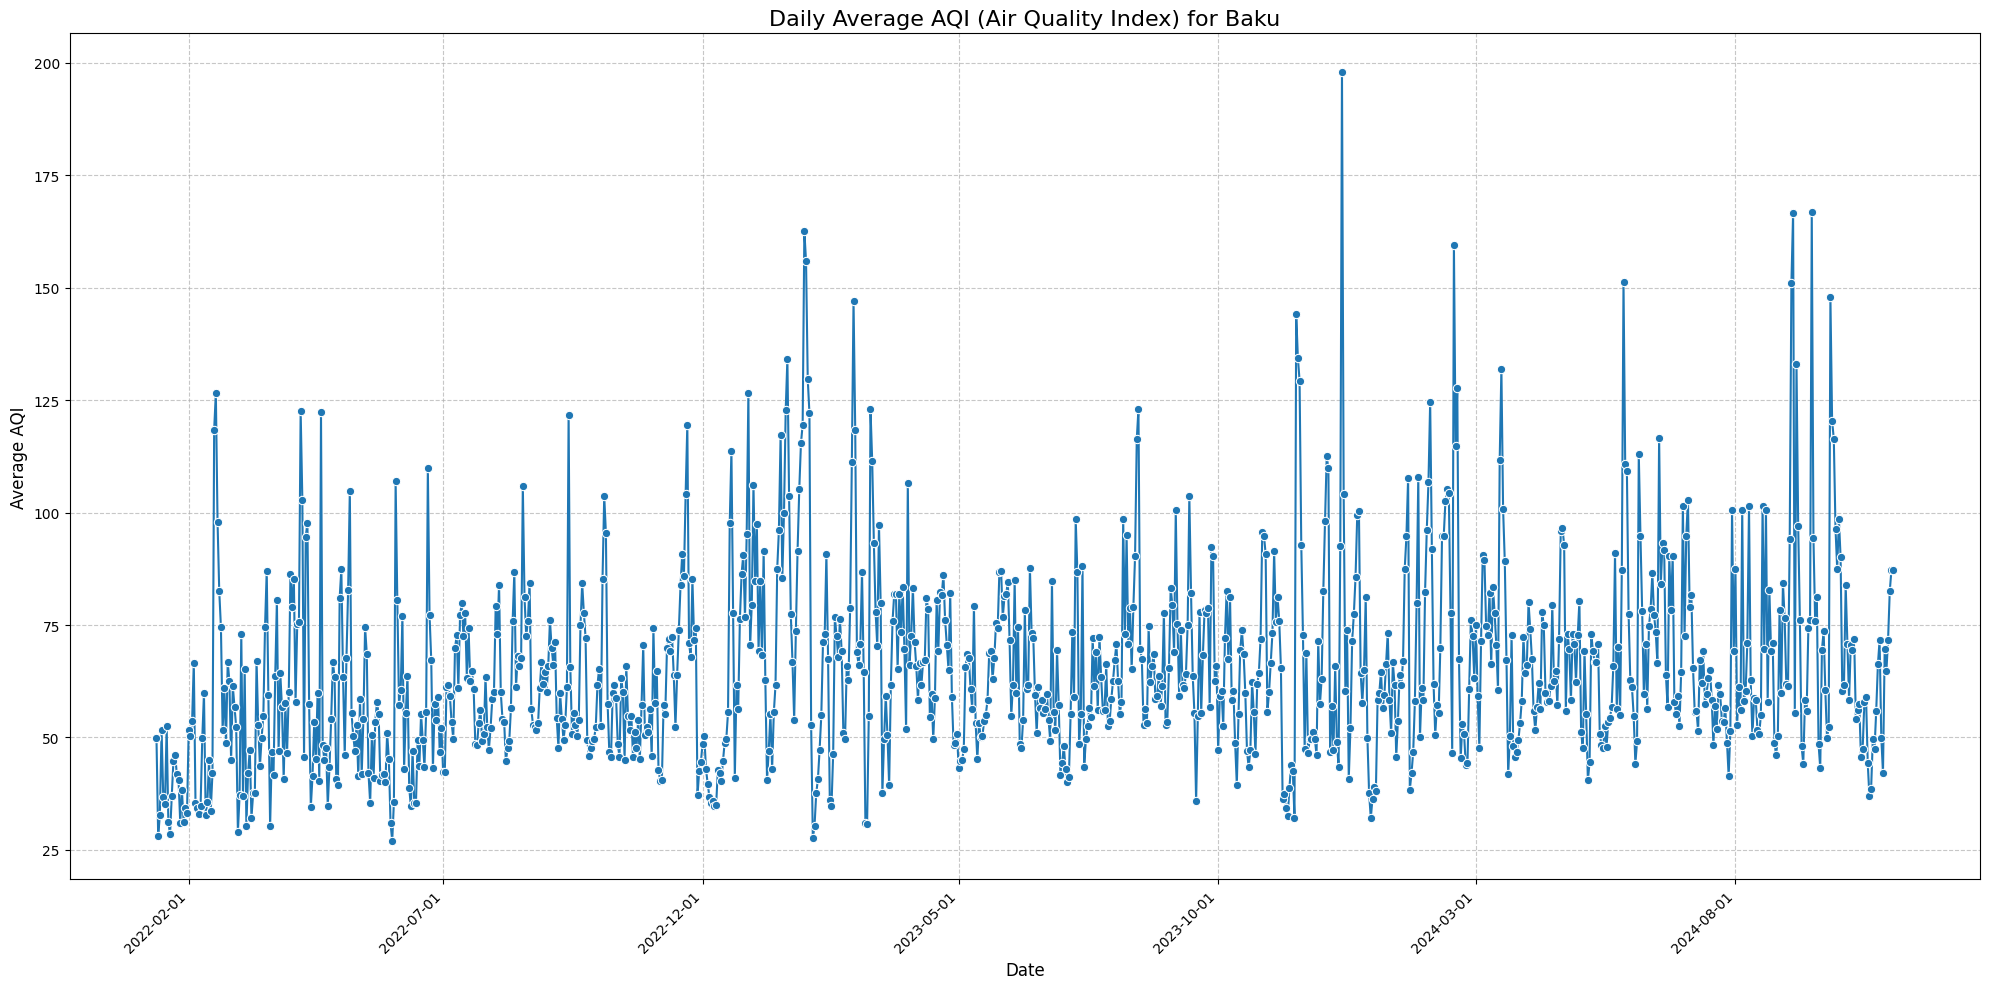

In [8]:
plt.figure(figsize = (20,10))
sns.lineplot(data = daily_aqi,marker='o')
plt.title('Daily Average AQI (Air Quality Index) for Baku', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average AQI', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')

# Show every 30th day on x-axis to avoid overcrowding
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

<h2> Perform ADF test to check for it's stationarity <h2>

In [9]:
aqi_daily = daily_aqi.dropna()
result = adfuller(aqi_daily)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -16.555024537095843
p-value: 1.9297951575417627e-29
Critical Values: {'1%': np.float64(-3.436752117511071), '5%': np.float64(-2.864366633740962), '10%': np.float64(-2.5682750226211546)}


<h2> Drawing the histogram and density distribution <h2>

<Axes: xlabel='aqi', ylabel='Count'>

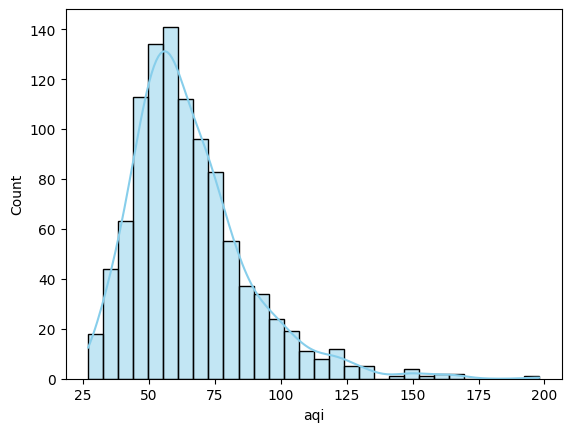

In [10]:
sns.histplot(aqi_daily, bins=30, kde=True, color='skyblue', edgecolor='black')

<h2> Removing outliers <h2>

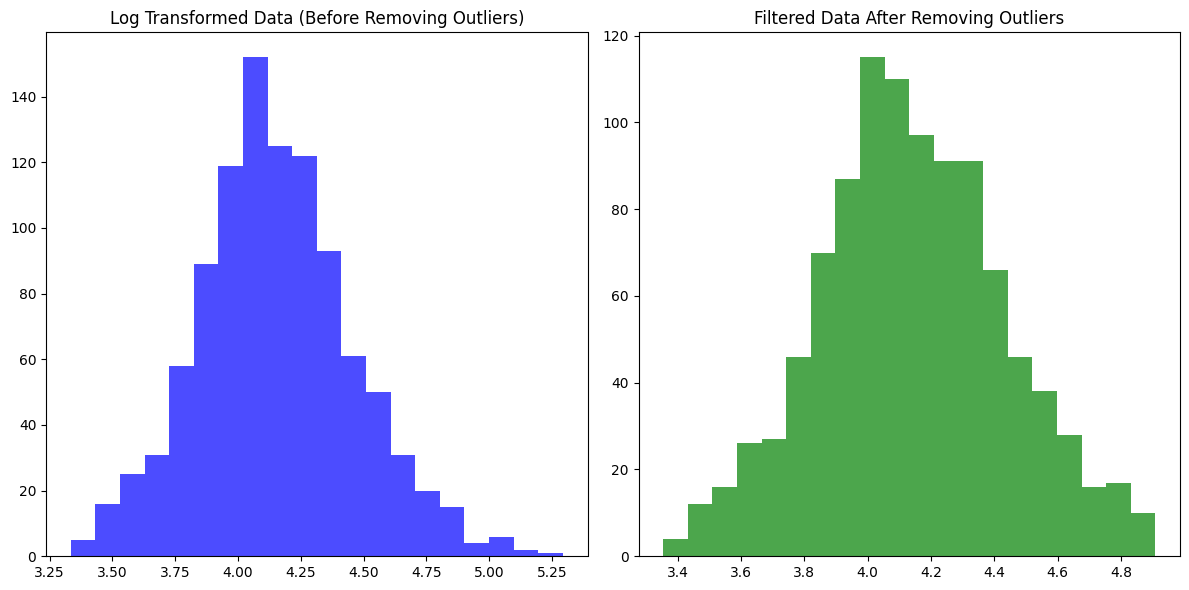

Original Data (Log-transformed):
timestamp
2022-01-13    3.927732
2022-01-14    3.368674
2022-01-15    3.522825
2022-01-16    3.962716
2022-01-17    3.629129
                ...   
2024-10-29    4.184794
2024-10-30    4.287166
2024-10-31    4.425565
2024-11-01    4.480967
2024-11-02    4.478700
Freq: D, Name: aqi, Length: 1025, dtype: float64

Filtered Data (after removing outliers):
timestamp
2022-01-13    3.927732
2022-01-14    3.368674
2022-01-15    3.522825
2022-01-16    3.962716
2022-01-17    3.629129
                ...   
2024-10-29    4.184794
2024-10-30    4.287166
2024-10-31    4.425565
2024-11-01    4.480967
2024-11-02    4.478700
Name: aqi, Length: 1013, dtype: float64


In [11]:
import numpy as np
aqi_daily_log = np.log(aqi_daily + 1)  # Add 1 to avoid log(0)

Q1 = aqi_daily_log.quantile(0.25)
Q3 = aqi_daily_log.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to remove outliers
filtered_aqi_daily = aqi_daily_log[(aqi_daily_log >= lower_bound) & (aqi_daily_log <= upper_bound)]

# Step 3: Plot the original and filtered data to visualize the effect of outlier removal
plt.figure(figsize=(12, 6))

# Plot Original Data (log-transformed values)
plt.subplot(1, 2, 1)
plt.hist(aqi_daily_log, bins=20, color='blue', alpha=0.7)
plt.title('Log Transformed Data (Before Removing Outliers)')

# Plot Filtered Data (log-transformed values after removing outliers)
plt.subplot(1, 2, 2)
plt.hist(filtered_aqi_daily, bins=20, color='green', alpha=0.7)
plt.title('Filtered Data After Removing Outliers')

plt.tight_layout()
plt.show()

# Print the original and filtered data
print("Original Data (Log-transformed):")
print(aqi_daily_log)
print("\nFiltered Data (after removing outliers):")
print(filtered_aqi_daily)

<h2> Drawing the histogram and density distribution after  data transformation <h2>

<Axes: xlabel='aqi', ylabel='Count'>

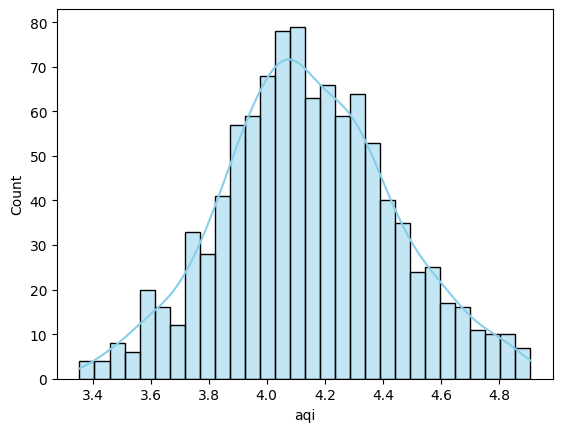

In [58]:
sns.histplot(filtered_aqi_daily, bins=30, kde=True, color='skyblue', edgecolor='black')

<h2> QQ distribution of  of the transformed data <h2>

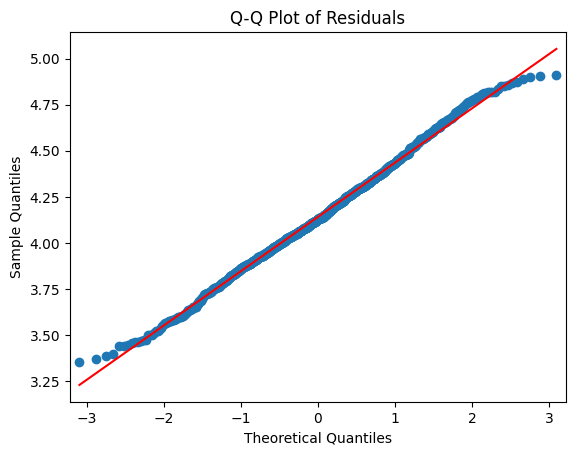

In [13]:
sm.qqplot(filtered_aqi_daily, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

<h2> ACF  and PACF <h2>

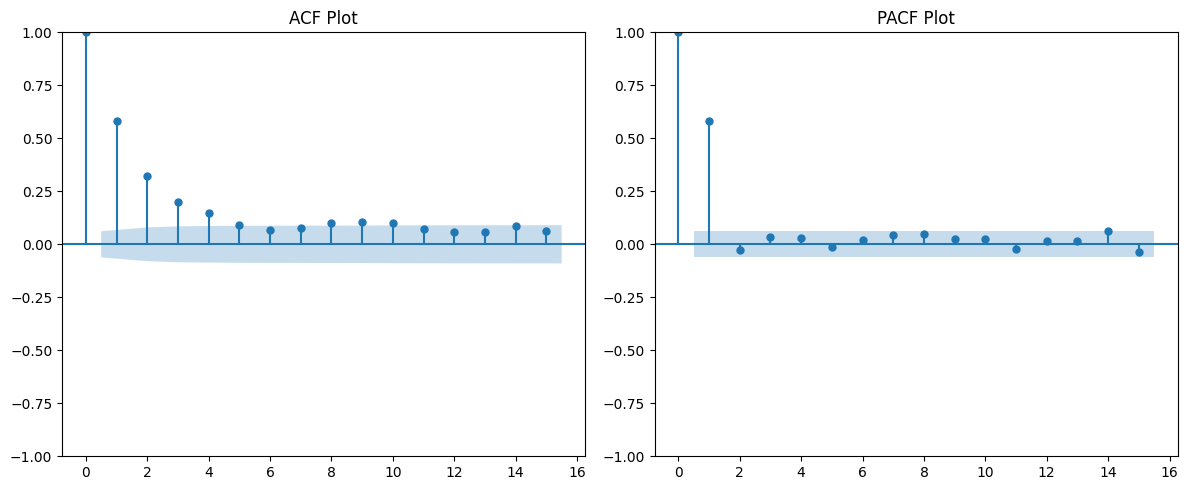

In [14]:


# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF on the left subplot
plot_acf(filtered_aqi_daily, lags=15, ax=axes[0])
axes[0].set_title("ACF Plot")

# Plot PACF on the right subplot
plot_pacf(filtered_aqi_daily, lags=15, ax=axes[1])
axes[1].set_title("PACF Plot")

# Show the combined plot
plt.tight_layout()
plt.show()


<h2> Train & Test split <h2>

In [15]:
split_percentage = 0.8
split_index =  int (len(aqi_daily)*split_percentage)

aqi_daily_train = filtered_aqi_daily[:split_index]
aqi_daily_test =  filtered_aqi_daily[split_index:]

print(len(aqi_daily_test))
print(len(aqi_daily_train))

print(aqi_daily_test.mean())

193
820
4.20398180471037


<h2> Training the model <h2>

In [50]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Assuming aqi_daily_test and aqi_daily_train are defined
predictions = []
actual_values = list(aqi_daily_test)
train_data = list(aqi_daily_train)

# List to store RMSE, AIC, and BIC values from each iteration
rmse_values = []
aic_values = []
bic_values = []

for i in range(0, len(aqi_daily_test), 3):
    # Fit the model with the training data
    model = ARIMA(train_data, order=(1, 1, 1))
    model_fit = model.fit()
   
    forecast = model_fit.forecast(steps=3)
    
    actual_iter_values = actual_values[i:i + 3]
    
    predicted_iter_values = forecast[:min(3, len(aqi_daily_test) - i)]  
    
    predictions.extend(predicted_iter_values)
    
    # Calculate RMSE for the current iteration
    rmse_iter = np.sqrt(np.mean((np.array(predicted_iter_values) - np.array(actual_iter_values)) ** 2))
    rmse_values.append(rmse_iter)

    # Store AIC and BIC values
    aic_values.append(model_fit.aic)
    bic_values.append(model_fit.bic)

    # Update train_data with actual values
    train_data.extend(actual_iter_values)

# After the loop, calculate the mean of the RMSE, AIC, and BIC values
mean_rmse = np.mean(rmse_values)
mean_aic = np.mean(aic_values)
mean_bic = np.mean(bic_values)

# Print the results
print(f'Mean Absolute Error (MAE): {np.mean(np.abs(np.array(predictions) - np.array(actual_values[:len(predictions)])))}')
print(f'Root Mean Squared Error (RMSE): {mean_rmse}')
print(f'Average AIC: {mean_aic}')
print(f'Average BIC: {mean_bic}')


Mean Absolute Error (MAE): 0.1890999762022419
Root Mean Squared Error (RMSE): 0.2127353890392164
Average AIC: -17.542313901894293
Average BIC: -3.091237028088417


<h2> Residuals <h2>

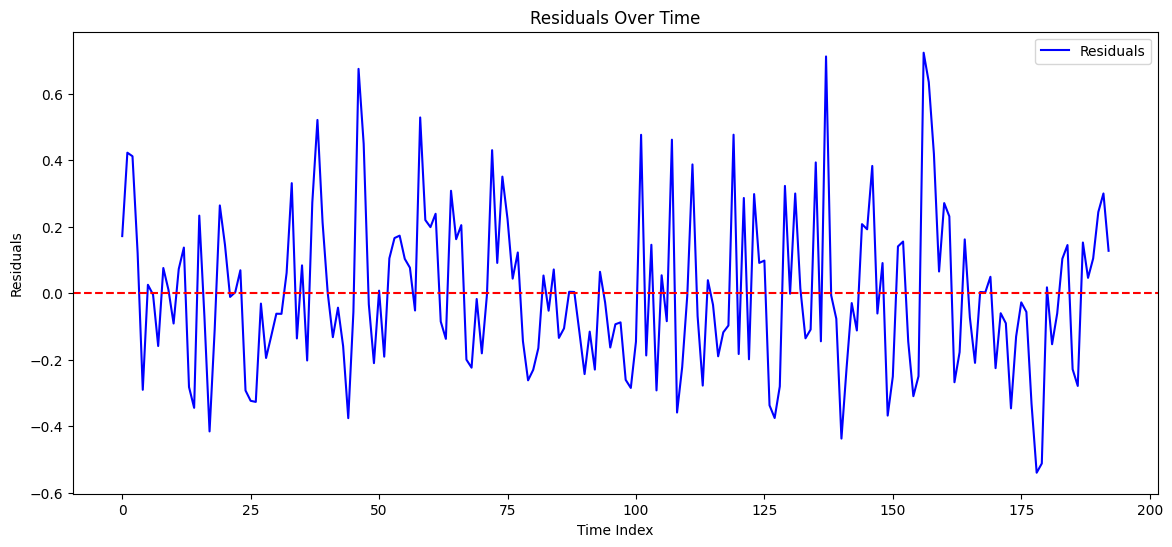

In [60]:
residuals =  np.array(actual_values)-np.array(predictions)
plt.figure(figsize=(14, 6))
plt.plot(residuals, label='Residuals', color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.legend()
plt.show()

<h2> Histogram and density estimation of the residuals <h2>

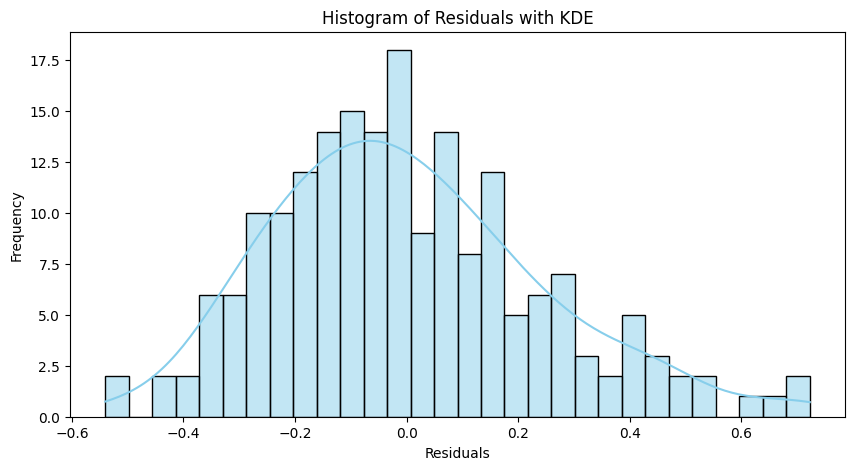

In [55]:
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True, color='skyblue', edgecolor='black')

# Adding labels and title
plt.title('Histogram of Residuals with KDE')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.show()

<h2> QQ  plot of the residuals <h2>

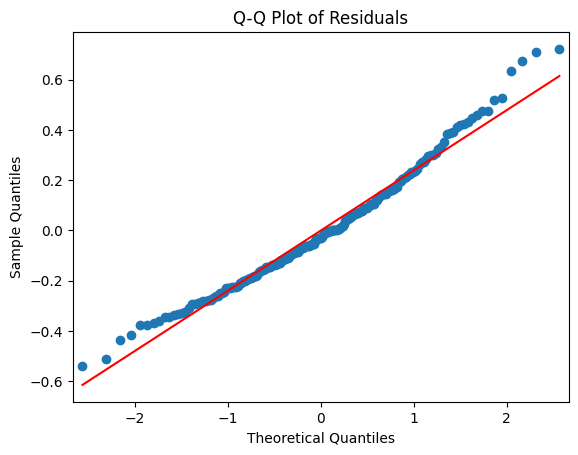

In [56]:
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

<h2> Model summary <h2>

In [57]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1012
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  15.815
Date:                Sun, 10 Nov 2024   AIC                            -25.630
Time:                        23:25:45   BIC                            -10.874
Sample:                             0   HQIC                           -20.025
                               - 1012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5517      0.026     21.145      0.000       0.501       0.603
ma.L1         -0.9887      0.005   -185.271      0.000      -0.999      -0.978
sigma2         0.0566      0.002     27.612      0.000       0.053       0.061
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                89.18
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.34
Prob(H) (two-sided):                  0.24   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""